In [1]:
# Imports
import os
import random
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision import models
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import functional as TF
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingLR
import zipfile


In [2]:

# Step 1: Mount Google Drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
# Step 2: Define paths (edit these if needed)
zip_path = "/content/drive/MyDrive/dataset_V6.zip"  # <-- change this if your file is in a folder
extract_dir = "/content/dataset_V6"

# Step 3: Unzip the dataset

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted dataset to: {extract_dir}")




# Step 4 (Optional): Copy the CSV if it's also on Drive
# If your CSV is in MyDrive, adjust the path accordingly

csv_drive_path = "/content/drive/MyDrive/dataset_V6.csv"
csv_colab_path = "/content/dataset_V6.csv"

!cp "{csv_drive_path}" "{csv_colab_path}"

print(f"✅ CSV copied to: {csv_colab_path}")




Mounted at /content/drive
✅ Extracted dataset to: /content/dataset_V6
✅ CSV copied to: /content/dataset_V6.csv


In [3]:
# class PadToSquareWithMean:
#     def __call__(self, image):
#         w, h = image.size
#         max_dim = max(w, h)
#         pad_left = (max_dim - w) // 2
#         pad_top = (max_dim - h) // 2
#         pad_right = max_dim - w - pad_left
#         pad_bottom = max_dim - h - pad_top

#         # Compute true mean color
#         np_img = np.array(image)
#         mean_color = tuple(np_img.reshape(-1, 3).mean(axis=0).astype(np.uint8))

#         return TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom),
#                       fill=mean_color, padding_mode='constant')

CSV_PATH = "dataset_V6.csv"
IMAGE_DIR = "/content/dataset_V6/dataset_V6"

# # ===== Base + Augmentation Transforms =====
# base_transform = transforms.Compose([
#     PadToSquareWithMean(),
#     transforms.Resize((300, 300)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])  # standard ImageNet normalization
# ])

# aug_transform = transforms.Compose([
#     PadToSquareWithMean(),
#     transforms.Resize((300, 300)),
#     transforms.RandomRotation(25),
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
#     transforms.RandomAffine(15, translate=(0.1,0.1)),
#     # transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as TF

# ---------- Utils ----------
def _mean_rgb(image: Image.Image):
    arr = np.array(image.convert("RGB"))
    return tuple(arr.reshape(-1, 3).mean(axis=0).astype(np.uint8).tolist())

class PadToSquareWithMean:
    def __call__(self, image: Image.Image):
        w, h = image.size
        max_dim = max(w, h)
        pad_left  = (max_dim - w) // 2
        pad_top   = (max_dim - h) // 2
        pad_right = max_dim - w - pad_left
        pad_bottom= max_dim - h - pad_top
        mean_color = _mean_rgb(image)
        return TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom),
                      fill=mean_color, padding_mode='constant')

class RotateWithMeanFill:
    def __init__(self, degrees=12):
        self.degrees = degrees
    def __call__(self, image: Image.Image):
        angle = transforms.RandomRotation.get_params([-self.degrees, self.degrees])
        mean_color = _mean_rgb(image)
        # expand=False keeps size; corners are filled with mean_color
        return TF.rotate(image, angle=angle, expand=False, fill=mean_color)

class AffineWithMeanFill:
    """
    Mild translation/scale/shear with mean-color fill.
    Set degrees if you want an extra tiny shear rotation; otherwise keep 0.
    """
    def __init__(self, degrees=0, translate=(0.08, 0.08), scale=(0.95, 1.05), shear=(-5, 5)):
        self.degrees = degrees
        self.translate = translate
        self.scale = scale
        self.shear = shear

    def __call__(self, image: Image.Image):
        # sample params the same way torchvision does
        angle, translations, scale, shear = transforms.RandomAffine.get_params(
            degrees=(-self.degrees, self.degrees),
            translate=self.translate,
            scale_ranges=self.scale,
            shears=self.shear,
            img_size=image.size
        )
        mean_color = _mean_rgb(image)
        return TF.affine(
            image,
            angle=angle,
            translate=translations,
            scale=scale,
            shear=shear,
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=mean_color
        )

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# ---------- Base (no aug) ----------
base_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# ---------- Augmented (train) ----------
aug_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((260, 260)),

    # Geometry (keep mild/realistic for microscope images)
    RotateWithMeanFill(degrees=12),              # ~±12°
    transforms.RandomHorizontalFlip(p=0.3),      # set to 0 if orientation-critical
    transforms.RandomVerticalFlip(p=0.1),        # consider disabling if S/I matters
    AffineWithMeanFill(
        degrees=0,                               # keep 0 unless you want extra tiny rotation
        translate=(0.10, 0.10),
        scale=(0.95, 1.05),
        shear=(-4, 4)
    ),

    # Photometric
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.10)
    ], p=0.6),

    # Light blur (focus drift)
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.2))
    ], p=0.3),

    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),

    # # Occlusion (simulates tools, glare, bubbles)
    # transforms.RandomErasing(
    #     p=0.25,
    #     scale=(0.02, 0.08),
    #     ratio=(0.3, 3.3),
    #     value='random'
    # ),
])

# ========== Dataset ==========
class CataractDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row["filename"] + ".jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Missing image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.data))

        label = self.label_map[row["label"].lower()]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# ========== Load and Prepare CSV ==========
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive label column from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"


# Keep only valid rows
df = df[df["label"].notna()]
df = df[["filename", "label"]]
# ========= Balance Function =========
def balance_dataset(df, image_dir, target_per_class =800):
    datasets = []
    class_counts = df['label'].value_counts().to_dict()
    augmented_summary = {}

    for label, count in class_counts.items():
        class_df = df[df['label'] == label]

        # Keep all original samples
        datasets.append(CataractDataset(class_df, image_dir, transform=base_transform))

        # Only add augmentation if class is below target
        if count < target_per_class:
            needed = target_per_class - count
            aug_rows = class_df.sample(needed, replace=True, random_state=42)
            datasets.append(CataractDataset(aug_rows, image_dir, transform=aug_transform))
            augmented_summary[label] = needed
        else:
            augmented_summary[label] = 0  # nothing added

    balanced_dataset = ConcatDataset(datasets)

    # Print summary
    print("\n=== Balancing Summary (No Downsampling) ===")
    for label, count in class_counts.items():
        added = augmented_summary[label]
        final_count = count + added
        print(f"{label:15s} | Original: {count:4d} | Added: {added:4d} | Final: {final_count:4d}")
    print(f"\nTotal balanced dataset size: {len(balanced_dataset)}")

    return balanced_dataset


df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive labels from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"

df = df[df["label"].notna()]
df = df[["filename", "label"]]

# ========= Split Dataset =========
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ========= Create Datasets =========
train_dataset = balance_dataset(train_df, IMAGE_DIR, target_per_class=800)
val_dataset = CataractDataset(val_df, IMAGE_DIR, transform=base_transform)
test_dataset = CataractDataset(test_df, IMAGE_DIR, transform=base_transform)

# ========= Create DataLoaders =========
BATCH_SIZE = 64
num_cpu = multiprocessing.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_cpu//2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cpu//2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cpu//2, pin_memory=True)



Train: 1404, Val: 301, Test: 301

=== Balancing Summary (No Downsampling) ===
mature          | Original:  367 | Added:  433 | Final:  800
low             | Original:  323 | Added:  477 | Final:  800
high            | Original:  298 | Added:  502 | Final:  800
poor dilation   | Original:  251 | Added:  549 | Final:  800
moderate        | Original:  165 | Added:  635 | Final:  800

Total balanced dataset size: 4000


In [4]:
import torch.nn as nn
from torchvision import models

def efficientnet_b2(weights="DEFAULT", fine_tune=True):
    """
    EfficientNet-B2 adapted to 5 classes.

    Parameters
    ----------
    weights : str | torchvision.models.EfficientNet_B2_Weights | None
        "DEFAULT"  → ImageNet-1K weights (torchvision ≥0.15).
        None       → random initialization.
        Or pass an explicit EfficientNet_B2_Weights enum.
    fine_tune : bool
        True  → freeze everything except last two MBConv blocks + classifier.
        False → leave all layers trainable.

    Returns
    -------
    model : nn.Module
    """

    # 1) Load backbone
    eff_weights = (
        models.EfficientNet_B2_Weights.DEFAULT if weights == "DEFAULT" else weights
    )
    model = models.efficientnet_b2(weights=eff_weights)

    # 2) Freeze / unfreeze
    if fine_tune:
        for p in model.parameters():
            p.requires_grad = False
        # Unfreeze the deepest layers (features.6 & features.7) and the classifier
        for name, p in model.named_parameters():
            # p.requires_grad = True

            if name.startswith(("features.6", "features.7", "classifier")):
                p.requires_grad = True

    # 3) Replace classifier head (EffNet-B2 head = Sequential[Dropout, Linear])
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, 5)   # 5 classes

    return model


Using device: cuda
Total number of samples: 2006

Class distribution:
label
mature           524
low              462
high             425
poor dilation    359
moderate         236
Name: count, dtype: int64


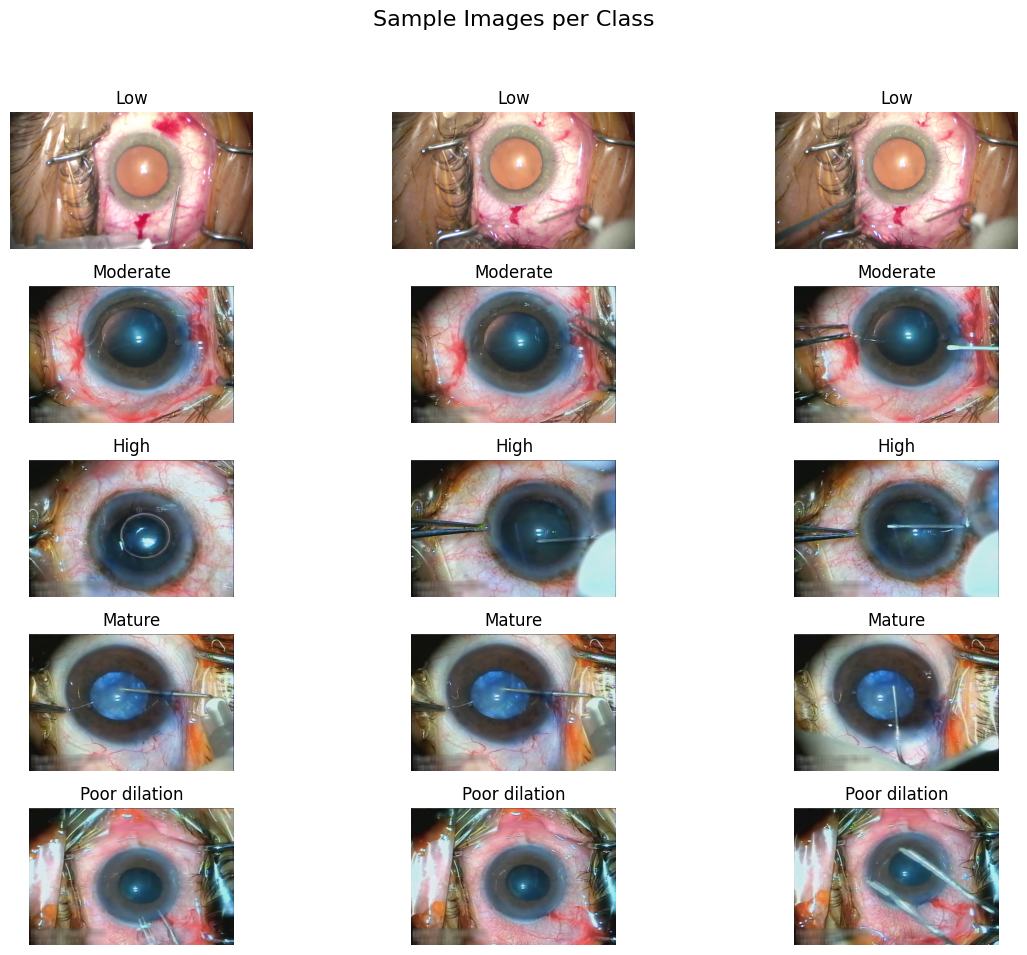

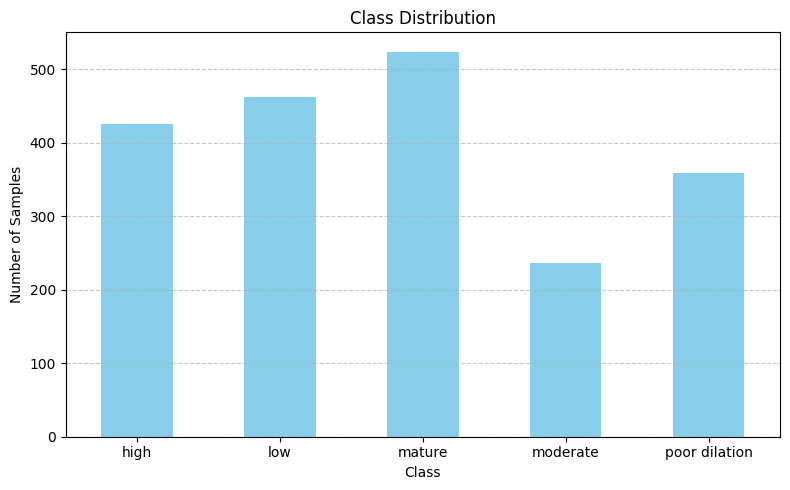

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 144MB/s]


Model is on device: cuda:0
Epoch: [1/60] | Step: [1/63] | Loss: 1.647295
Epoch: [1/60] | Step: [3/63] | Loss: 1.622121
Epoch: [1/60] | Step: [5/63] | Loss: 1.652196
Epoch: [1/60] | Step: [7/63] | Loss: 1.547168
Epoch: [1/60] | Step: [9/63] | Loss: 1.586103
Epoch: [1/60] | Step: [11/63] | Loss: 1.566903
Epoch: [1/60] | Step: [13/63] | Loss: 1.576930
Epoch: [1/60] | Step: [15/63] | Loss: 1.594657
Epoch: [1/60] | Step: [17/63] | Loss: 1.544597
Epoch: [1/60] | Step: [19/63] | Loss: 1.532702
Epoch: [1/60] | Step: [21/63] | Loss: 1.522797
Epoch: [1/60] | Step: [23/63] | Loss: 1.494624
Epoch: [1/60] | Step: [25/63] | Loss: 1.491533
Epoch: [1/60] | Step: [27/63] | Loss: 1.486061
Epoch: [1/60] | Step: [29/63] | Loss: 1.503821
Epoch: [1/60] | Step: [31/63] | Loss: 1.497271
Epoch: [1/60] | Step: [33/63] | Loss: 1.471290
Epoch: [1/60] | Step: [35/63] | Loss: 1.479045
Epoch: [1/60] | Step: [37/63] | Loss: 1.426563
Epoch: [1/60] | Step: [39/63] | Loss: 1.425067
Epoch: [1/60] | Step: [41/63] | Loss: 

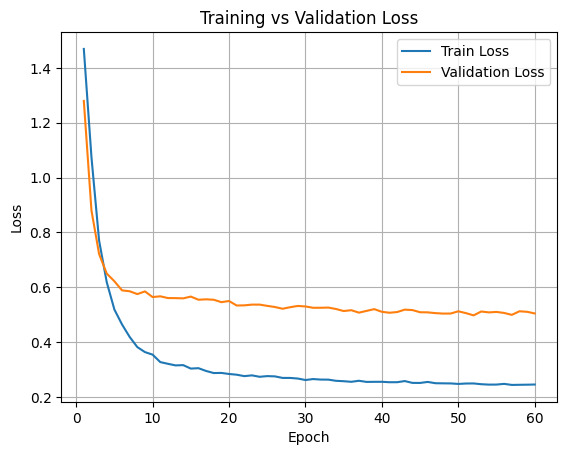

               precision    recall  f1-score   support

          low     0.9565    0.9565    0.9565        69
     moderate     0.9062    0.8286    0.8657        35
         high     0.8676    0.9219    0.8939        64
       mature     0.9359    0.9241    0.9299        79
poor dilation     0.9074    0.9074    0.9074        54

     accuracy                         0.9169       301
    macro avg     0.9147    0.9077    0.9107       301
 weighted avg     0.9176    0.9169    0.9169       301


Overall Accuracy: 0.9169
Macro F1-score  : 0.9107
Weighted F1-score: 0.9169


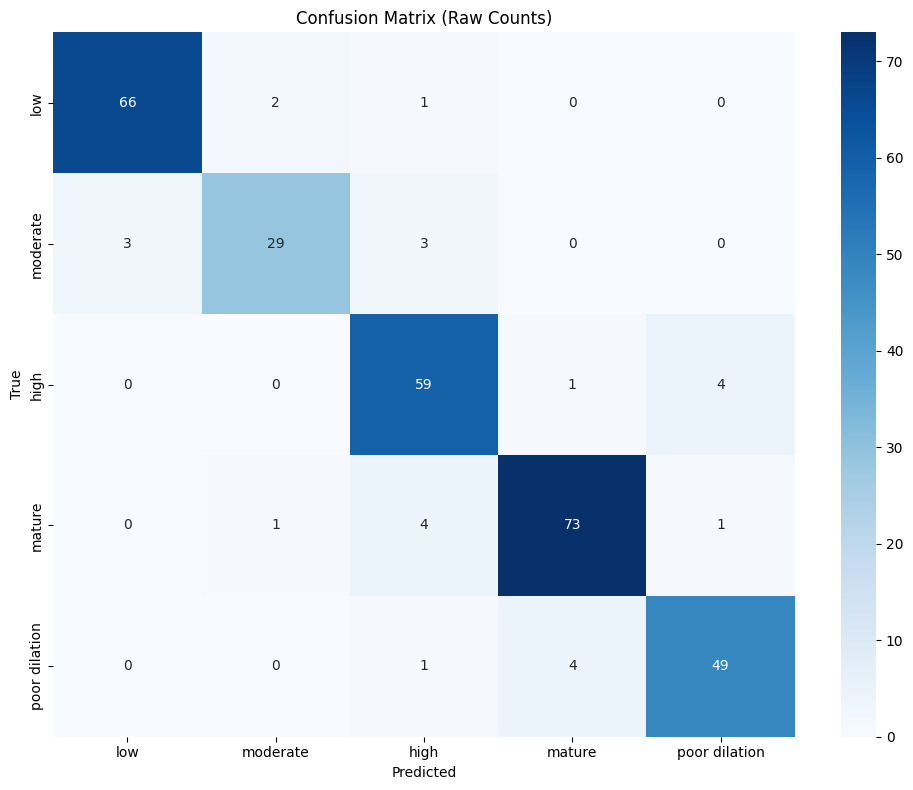

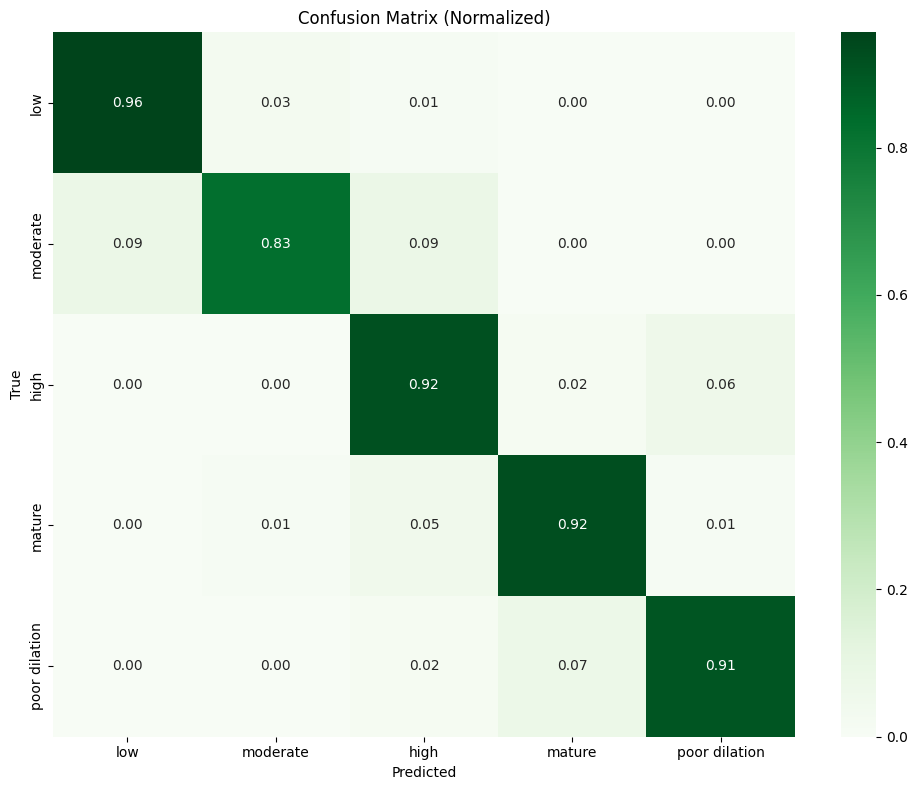

In [5]:
CSV_PATH = "/content/dataset_V6.csv"
IMAGE_DIR = "/content/dataset_V6/dataset_V6"

# train_loader, val_loader, test_loader, class_weights_tensor, df = get_dataloaders()


# Params
num_epochs = 60
lr = 1e-3
patience = 8
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# Print dataset statistics
print(f"Total number of samples: {len(df)}")
print("\nClass distribution:")
print(df['label'].value_counts())

# Define the class labels (ordered)
classes = ["low", "moderate", "high", "mature", "poor dilation"]

# Create a subplot grid: 4 rows (classes) x 3 columns (images)
fig, axs = plt.subplots(len(classes), 3, figsize=(12, 10))
fig.suptitle("Sample Images per Class", fontsize=16)

# Loop over each class
for i, cls in enumerate(classes):
    class_samples = df[df["label"] == cls].head(3)
    for j, (_, row) in enumerate(class_samples.iterrows()):
        img_path = os.path.join(IMAGE_DIR, row["filename"] + ".jpg")
        try:
            image = Image.open(img_path)
            axs[i, j].imshow(image)
            axs[i, j].axis("off")
            axs[i, j].set_title(f"{cls.capitalize()}")
        except FileNotFoundError:
            axs[i, j].axis("off")
            axs[i, j].set_title("Image not found")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # adjust for suptitle
plt.show()

# Plot bar chart of class distribution
plt.figure(figsize=(8, 5))
df["label"].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




# Training
# model = resnet18(fine_tune=False).to(device)  # change to True if you want to fine-tune deeper layers
model = efficientnet_b2(fine_tune=True).to(device)
# Loss Function
# class_weights_tensor = class_weights_tensor.to(device)  # move to GPU
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)

# Optimizer
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

optimizer = torch.optim.AdamW([
    {"params": model.features.parameters(), "lr": 3e-5},   # very small LR for backbone
    {"params": model.classifier.parameters(), "lr": 3e-4}  # higher LR for classifier
], weight_decay=1e-4)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


train_loss = []
valid_loss = []

print(f"Model is on device: {next(model.parameters()).device}")

# Train Loop
num_steps = len(train_loader)
for epochs in range(num_epochs):
    model.train()
    running_loss = 0.0
    for j, (imgs, lbls) in enumerate(train_loader):
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = loss_fn(out, lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if j % 2 == 0:
            print('Epoch: [{}/{}] | Step: [{}/{}] | Loss: {:.6f}'
                  .format(epochs+1, num_epochs, j+1, num_steps, loss.item()))
    train_loss.append(running_loss / num_steps)
    print('Epoch: [{}/{}] | Loss: {:.6f}'
          .format(epochs+1, num_epochs, loss.item()))

#---------------------
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        running_valid_loss = 0.0
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            loss_val = loss_fn(out, lbls)
            running_valid_loss += loss_val.item()
            predicted = torch.argmax(out, dim=1)
            correct += (predicted == lbls).sum().item()
            total += lbls.size(0)
        avg_val_loss = running_valid_loss / len(val_loader)
        valid_loss.append(avg_val_loss)
        print('Valid Loss: {:.6f} | Acc: {:.4f}'.format(valid_loss[-1], correct / total))

        # Step the scheduler
        # scheduler.step(avg_val_loss)


        # Early stopping
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

# Plot losses
plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
plt.plot(range(1, len(valid_loss)+1), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()




# # Predictions and true labels
# all_preds = []
# all_labels = []
#
# model.eval()
# with torch.no_grad():
#     for imgs, lbls in test_loader:
#         imgs = imgs.to(device)
#         outputs = model(imgs)
#         preds = torch.argmax(outputs, dim=1).cpu()
#         all_preds.extend(preds.numpy())
#         all_labels.extend(lbls.numpy())
#
# # Classification Report
# print(classification_report(all_labels, all_preds, target_names=classes))
#
# # Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()
#


# Evaluation
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Print classification report
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(report)

# Save report as a dataframe (optional)
report_df = pd.DataFrame(classification_report(all_labels, all_preds, target_names=classes, output_dict=True)).T
report_df.to_csv("classification_report.csv")

# Accuracy and F1 scores
print(f"\nOverall Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"Macro F1-score  : {f1_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Weighted F1-score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot raw confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Raw Counts)')
plt.tight_layout()
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Normalized)')
plt.tight_layout()
plt.show()



torch.save(model.state_dict(), "efficientnet_b2_cataract.pth")


Embeddings shape: (1404, 1408)  | Labels: (1404,)


/tmp/ipython-input-3840853860.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('tab10', num_classes)


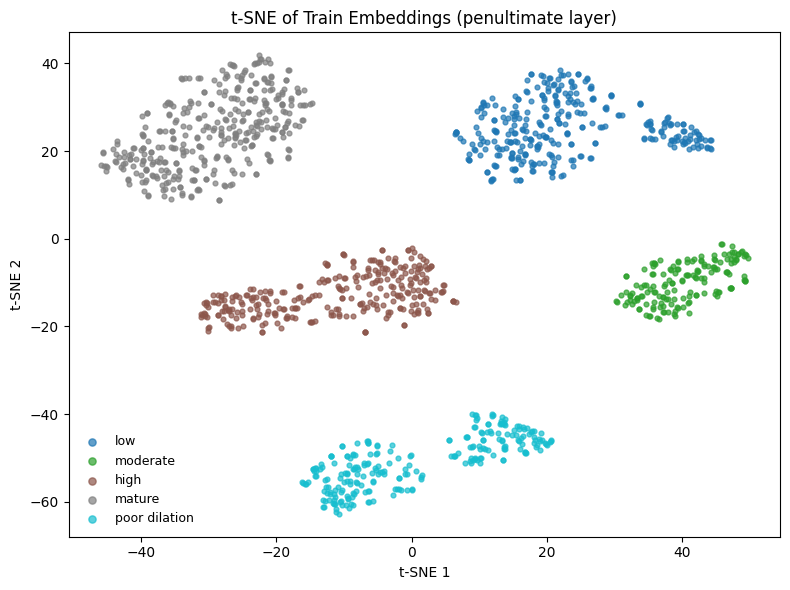

In [6]:
# --- 0) No-aug train loader for feature extraction ---
# Use the same base_transform you already use for val/test
feat_dataset = CataractDataset(train_df.reset_index(drop=True), IMAGE_DIR, transform=base_transform)
feat_loader  = DataLoader(feat_dataset, batch_size=64, shuffle=False,
                          num_workers=num_cpu//2, pin_memory=True)

# If you need label names in a fixed order:
classes = ["low", "moderate", "high", "mature", "poor dilation"]
name_to_idx = {c:i for i,c in enumerate(classes)}

# --- 1) Collect penultimate-layer embeddings with a hook ---
import torch
import numpy as np

model.eval()
emb_chunks, lab_chunks = [], []

# For torchvision/timm EfficientNet, the classifier is in model.classifier (Sequential[Dropout, Linear]).
# A forward *pre*-hook on `classifier` gives the tensor right before the head = penultimate embedding.
def _feat_hook(module, inputs):
    # inputs is a tuple; take the tensor [B, D]
    x = inputs[0].detach().cpu()
    emb_chunks.append(x)

hook_handle = model.classifier.register_forward_pre_hook(lambda m, inp: _feat_hook(m, inp))

with torch.no_grad():
    for imgs, lbls in feat_loader:
        imgs = imgs.to(device)
        _ = model(imgs)                      # forward pass triggers the hook
        lab_chunks.append(lbls.cpu())

# Clean up the hook
hook_handle.remove()

embeddings = torch.cat(emb_chunks, dim=0).numpy()       # [N, D]
labels     = torch.cat(lab_chunks, dim=0).numpy()       # [N]

print("Embeddings shape:", embeddings.shape, " | Labels:", labels.shape)

# --- 2) t-SNE (PCA -> t-SNE is faster/stabler) ---
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_pca  = PCA(n_components=min(50, embeddings.shape[1]-1), random_state=42).fit_transform(embeddings)
tsne   = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
X_2d   = tsne.fit_transform(X_pca)                       # [N, 2]

# --- 3) Plot ---
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(8,6))
num_classes = len(classes)
cmap = matplotlib.cm.get_cmap('tab10', num_classes)
for idx, cls in enumerate(classes):
    mask = (labels == idx)
    plt.scatter(X_2d[mask,0], X_2d[mask,1], s=12, alpha=0.7, label=cls, color=cmap(idx))

plt.title("t-SNE of Train Embeddings (penultimate layer)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(markerscale=1.5, fontsize=9, frameon=False)
plt.tight_layout()
plt.show()

# (Optional) Save for later analysis
import pandas as pd
tsne_df = pd.DataFrame({"x": X_2d[:,0], "y": X_2d[:,1], "label": [classes[i] for i in labels]})
tsne_df.to_csv("tsne_train_embeddings.csv", index=False)


Test embeddings: (301, 1408) labels: (301,)


/tmp/ipython-input-2967457933.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('tab10', num_classes)


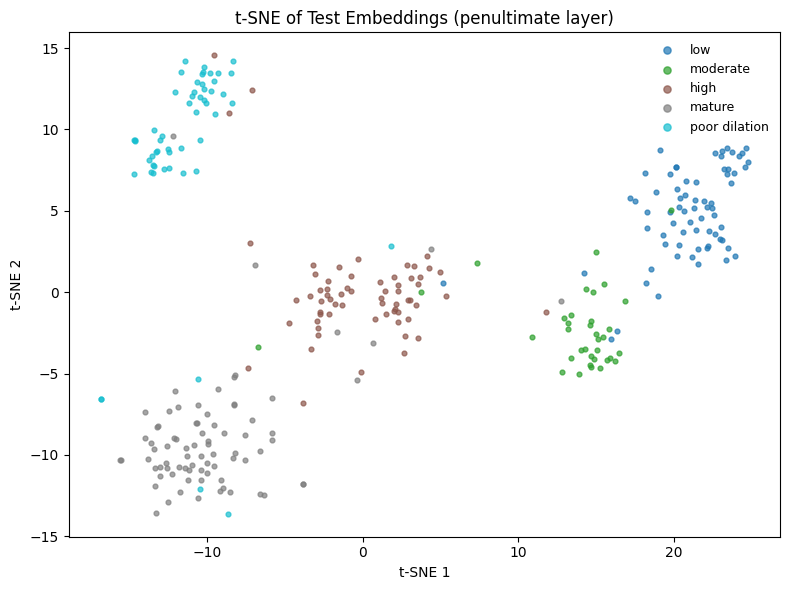

Saved: tsne_test_embeddings.csv and tsne_test_plot.png


In [7]:
# ===== 0) Test loader (no augmentation) =====
test_dataset = CataractDataset(test_df.reset_index(drop=True), IMAGE_DIR, transform=base_transform)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False,
                          num_workers=max(0, num_cpu//2), pin_memory=True)

# ===== 1) Helper: collect penultimate embeddings via a pre-hook on model.classifier =====
import torch
import numpy as np

def collect_penultimate_embeddings(model, loader, device):
    model.eval()
    emb_chunks, lab_chunks = [], []

    def _feat_hook(module, inputs):
        x = inputs[0].detach().cpu()  # [B, D] entering the final Linear
        emb_chunks.append(x)

    handle = model.classifier.register_forward_pre_hook(lambda m, inp: _feat_hook(m, inp))
    try:
        with torch.no_grad():
            for imgs, lbls in loader:
                imgs = imgs.to(device)
                _ = model(imgs)              # triggers the hook
                lab_chunks.append(lbls.cpu())
    finally:
        handle.remove()

    embeddings = torch.cat(emb_chunks, dim=0).numpy()   # [N, D]
    labels     = torch.cat(lab_chunks, dim=0).numpy()   # [N]
    return embeddings, labels

embeddings_test, labels_test = collect_penultimate_embeddings(model, test_loader, device)
print("Test embeddings:", embeddings_test.shape, "labels:", labels_test.shape)

# ===== 2) PCA -> t-SNE =====
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

D = embeddings_test.shape[1]
n_pca = max(2, min(50, D - 1))  # safe bounds
X_pca = PCA(n_components=n_pca, random_state=42).fit_transform(embeddings_test)

tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
X2_test = tsne.fit_transform(X_pca)  # [N, 2]

# ===== 3) Plot =====
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(8, 6))
num_classes = len(classes)
cmap = matplotlib.cm.get_cmap('tab10', num_classes)

for idx, cls in enumerate(classes):
    mask = (labels_test == idx)
    plt.scatter(X2_test[mask, 0], X2_test[mask, 1], s=12, alpha=0.7, label=cls, color=cmap(idx))

plt.title("t-SNE of Test Embeddings (penultimate layer)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(markerscale=1.5, fontsize=9, frameon=False)
plt.tight_layout()
plt.savefig("tsne_test_plot.png", dpi=200)
plt.show()

# ===== 4) Save CSV =====
import pandas as pd
tsne_test_df = pd.DataFrame({
    "x": X2_test[:, 0],
    "y": X2_test[:, 1],
    "label": [classes[i] for i in labels_test]
})
tsne_test_df.to_csv("tsne_test_embeddings.csv", index=False)
print("Saved: tsne_test_embeddings.csv and tsne_test_plot.png")
